In [1]:
import pandas as pd
import os
import sys

sys.path.append("../..")
from common.utils import timestep_csv_names
from common.constants import DATAFOLDER

root_dir = os.path.join(DATAFOLDER.data_root_path, "one_day_data")

_timestep_csv_names = timestep_csv_names(delta=10)

dates, rain_amounts, start_times, end_times = [], [], [], []
for year in os.listdir(root_dir):
    for month in os.listdir(root_dir + f"/{year}"):
        for date in os.listdir(root_dir + f"/{year}/{month}"):
            minimum_data_length = 40
            max_rainfall = 0
            start_time = None
            end_time = None
            for csv_filename in _timestep_csv_names:
                csv_path = os.path.join(
                        root_dir,
                        year, month, date, csv_filename
                    )
                parquet_path = csv_path.replace(".csv", ".parquet.gzip")
                parquet_df = pd.read_parquet(parquet_path, engine="pyarrow")

                if parquet_df["hour-rain"].max() >= 5:
                    if parquet_df["hour-rain"].max() > max_rainfall:
                        max_rainfall = parquet_df["hour-rain"].max()
                    if start_time is None:
                        start_time = csv_filename.replace(".csv", "")

                if start_time is not None and parquet_df["hour-rain"].max() < 5:
                    end_time = csv_filename.replace(".csv", "")
                    if _timestep_csv_names.index(end_time+".csv") - _timestep_csv_names.index(start_time+".csv") > 7:
                        dates.append(date)
                        rain_amounts.append(max_rainfall)
                        start_times.append(start_time)
                        end_times.append(end_time)
                        
                    start_time = None
                    end_time = None
                    max_rainfall = 0

                if len(parquet_df.index) < minimum_data_length:
                    minimum_data_length = len(parquet_df.index)

            if minimum_data_length > 0 and start_time is not None and end_time is None:
                end_time = csv_filename.replace(".csv", "")
                if _timestep_csv_names.index(end_time+".csv") - _timestep_csv_names.index(start_time+".csv") > 7:
                    dates.append(date)
                    rain_amounts.append(max_rainfall)
                    start_times.append(start_time)
                    end_times.append(end_time)

df = pd.DataFrame({"date": dates, "rain": rain_amounts, "start_time": start_times, "end_time": end_times})
df = df.sort_values(by="rain", ascending=False)
df.reset_index()
df.head()

,date,rain,start_time,end_time
71,2020-08-01,88.0,3-40,7-10
135,2020-10-12,82.0,6-10,9-40
1,2020-07-27,80.0,10-50,13-40
21,2020-07-12,76.5,21-10,23-20
34,2020-09-14,76.0,4-50,7-0


In [4]:
over_50_rainfall = df.loc[df["rain"] > 50]
print("Over 50 mm/h rainfall is", (len(over_50_rainfall)/len(df)) * 100, "%")

Over 50 mm/h rainfall is 11.224489795918368 %


In [57]:
import numpy as np


def calc_u_v(df, ob_point):
    wind_dir = float(df["WD1"])
    wind_speed = float(df["WS1"])

    rads = np.radians(float(wind_dir))
    wind_u, wind_v = -1 * wind_speed * np.cos(rads), -1 * wind_speed * np.sin(rads)
    # wind_u_v = wind_components(wind_speed * units("m/s"), wind_dir * units.deg)

    return [
        ob_point,
        round(wind_u, 5),
        round(wind_v, 5),
    ]  # (index, u wind, v wind) u: X (East-West) v: Y(North-South)


target_cols = ['hour-rain', 'AT1', 'RH1', 'WS1', 'PRS', 'SLP', 'V-Wind', "U-Wind"]
rain_other_param_df = pd.DataFrame(columns=target_cols)
diff_rain_other_param_df = pd.DataFrame(columns=target_cols)

for i in over_50_rainfall.index:
    date = over_50_rainfall.loc[i, "date"]
    year, month = date.split("-")[0], date.split("-")[1]

    start_time = over_50_rainfall.loc[i, "start_time"]
    end_time = over_50_rainfall.loc[i, "end_time"]

    start_time_idx, end_time_idx = _timestep_csv_names.index(start_time+".csv"), _timestep_csv_names.index(end_time+".csv")

    for time_idx in range(start_time_idx, end_time_idx + 1):
        _time = _timestep_csv_names[time_idx]
        _time = _time.replace(".csv", "")
        data_file_path = os.path.join(root_dir, year, month, date, _time+".parquet.gzip")
        parquet_df = pd.read_parquet(data_file_path, engine="pyarrow")
        wind_df = pd.DataFrame([calc_u_v(parquet_df.loc[i, :], i) for i in parquet_df.index], columns=["OB-Point", "U-Wind", "V-Wind"])
        parquet_df["V-Wind"], parquet_df["U-Wind"] = wind_df["V-Wind"], wind_df["U-Wind"]

        rain_other_param_df = rain_other_param_df.append(parquet_df[target_cols], ignore_index=True)

        # calculate the difference before 10 minutes data
        if time_idx == start_time_idx:
            ten_minutes_before_df = parquet_df[target_cols]
            ten_minutes_before_df["timestamp"] = time_idx
        else:
            parquet_df = parquet_df[target_cols]
            parquet_df["timestamp"] = time_idx
            diff_parquet_df = parquet_df.subtract(ten_minutes_before_df)
            diff_rain_other_param_df = diff_rain_other_param_df.append(diff_parquet_df, ignore_index=True)

            ten_minutes_before_df = parquet_df

            assert diff_parquet_df["timestamp"].max() == 1 and diff_parquet_df["timestamp"].sum() / len(diff_parquet_df) == 1

        # Check outlier of Wind Speed (WS1)
        # if parquet_df["WS1"].max() > 40:
        #     print(date, _time)

rain_other_param_df.head()

/home/akira/anaconda3/envs/p-poteka/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,hour-rain,AT1,RH1,WS1,PRS,SLP,V-Wind,U-Wind
0,0.0,33.0,42.0,0.4,1007.4,1010.3,-0.22368,-0.33162
1,0.0,33.4,50.5,0.5,1004.6,1010.8,-0.18730,0.46359
2,0.5,25.9,61.5,3.7,1009.6,1011.3,2.52339,2.70601
3,0.0,32.0,48.6,0.9,1007.8,1010.3,-0.01571,-0.89986
4,0.0,32.2,46.5,1.6,1002.7,1010.3,-0.82406,1.37147


In [58]:
rain_other_param_df.describe()

,hour-rain,AT1,RH1,WS1,PRS,SLP,V-Wind,U-Wind
count,14113.000000,14113.000000,14113.000000,14113.000000,14113.000000,14113.000000,14113.000000,14113.000000
mean,4.648834,27.208905,71.802237,0.936796,1007.065284,1009.834189,0.091121,0.193939
std,9.934367,2.470767,11.472126,1.696219,2.531082,2.261867,1.702478,0.900254
min,0.000000,22.700000,29.600000,0.000000,997.200000,999.200000,-19.497030,-26.895900
25%,0.000000,25.400000,64.700000,0.400000,1005.400000,1008.400000,-0.272390,-0.187790
50%,0.500000,26.600000,74.700000,0.600000,1007.300000,1009.900000,0.036640,0.157600
75%,4.000000,28.400000,80.600000,1.100000,1008.900000,1011.400000,0.391260,0.536230
max,88.000000,38.500000,94.800000,46.900000,1013.400000,1016.800000,46.892860,18.600000


In [59]:
diff_rain_other_param_df.head()

,hour-rain,AT1,RH1,WS1,PRS,SLP,V-Wind,U-Wind,timestamp
0,0.0,0.1,-1.2,-0.1,-0.1,-0.1,0.31139,0.61851,1.0
1,0.0,0.2,-0.8,-0.1,-0.1,-0.1,0.06369,-0.08317,1.0
2,22.5,-1.4,11.5,-3.0,0.5,0.5,-2.48675,-2.00697,1.0
3,0.0,1.1,-0.8,-0.1,0.0,-0.1,0.41571,0.20704,1.0
4,0.0,0.4,0.1,-0.5,0.0,0.0,0.34185,-0.38280,1.0


In [60]:
diff_rain_other_param_df.describe()

,hour-rain,AT1,RH1,WS1,PRS,SLP,V-Wind,U-Wind,timestamp
count,13427.000000,13427.000000,13427.000000,13427.000000,13427.000000,13427.000000,13427.000000,13427.000000,13427.0
mean,0.005660,-0.194579,0.830900,-0.018085,0.048900,0.051030,-0.006057,-0.002533,1.0
std,3.445464,0.640353,2.179015,0.760065,0.219597,0.228894,0.804625,0.793709,0.0
min,-26.500000,-6.567934,-12.132097,-25.200000,-1.300000,-3.300000,-18.894810,-17.144560,1.0
25%,0.000000,-0.300000,-0.300000,-0.200000,-0.100000,-0.100000,-0.266560,-0.281785,1.0
50%,0.000000,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.000000,0.100000,1.500000,0.200000,0.200000,0.200000,0.252375,0.261970,1.0
max,27.000000,3.289301,25.682975,18.600000,1.761062,3.600000,17.244800,27.191100,1.0


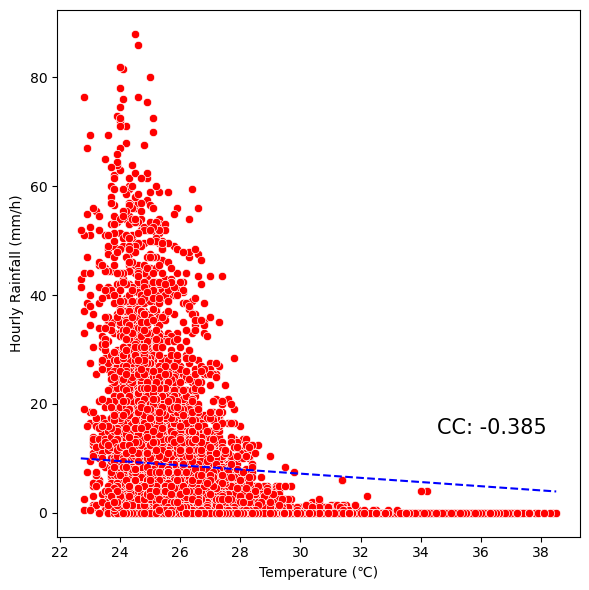

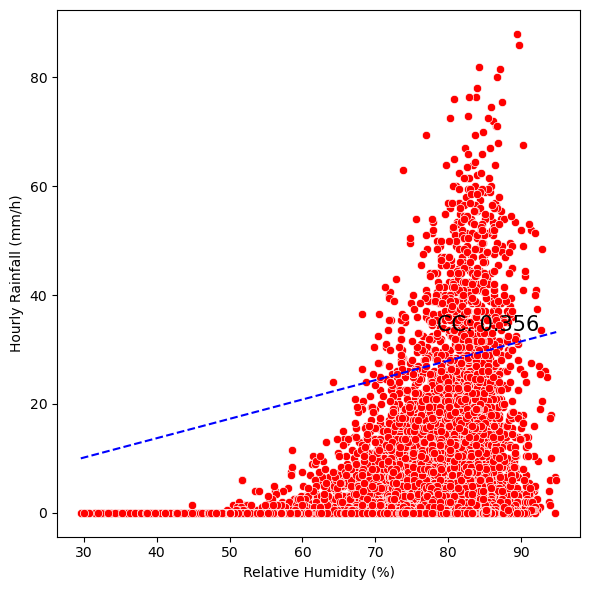

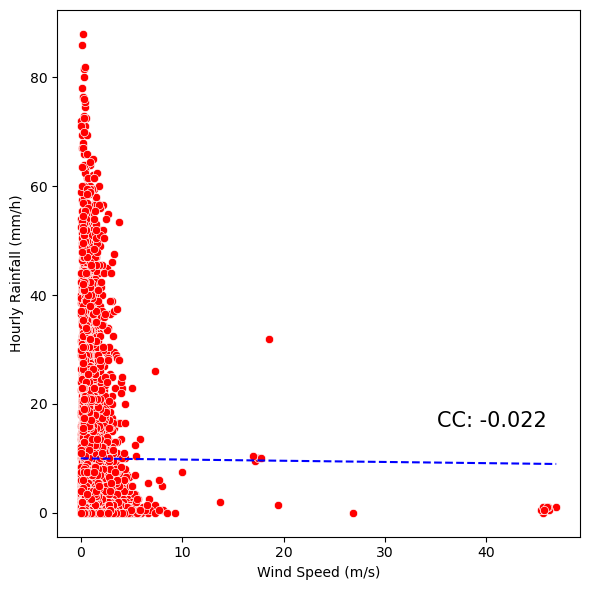

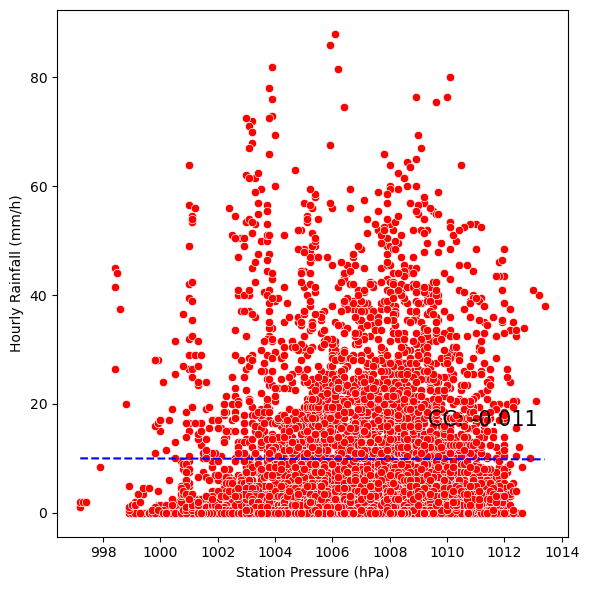

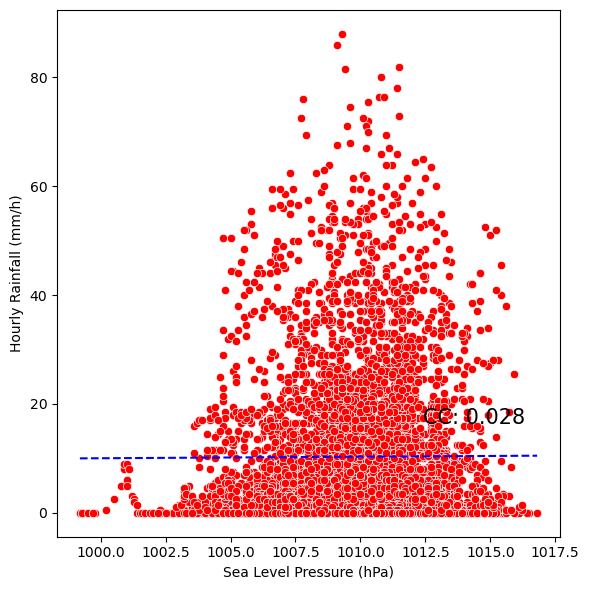

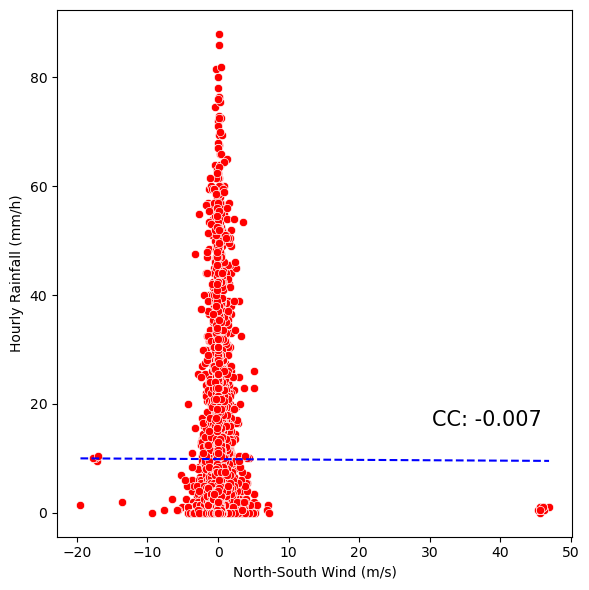

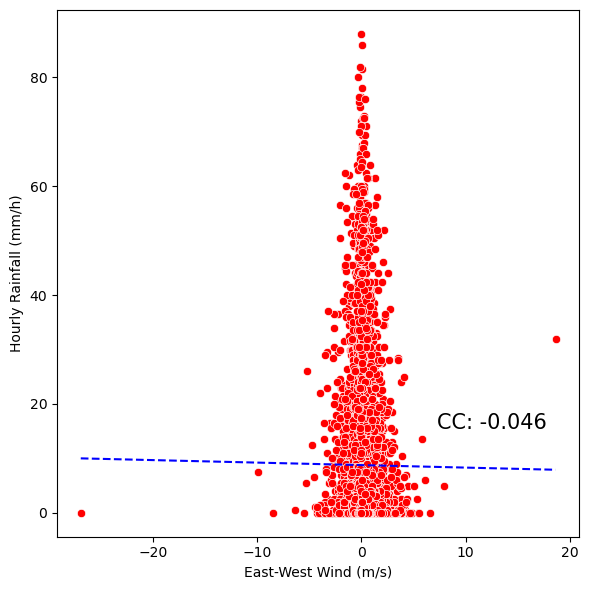

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

parameter_info = {}
for col in target_cols:
    if col == "hour-rain":
        parameter_info["hour-rain"] = {"label": "Hourly Rainfall (mm/h)"}
    elif col == "AT1":
        parameter_info["AT1"] = {"label": "Temperature (℃)"}
    elif col == "RH1":
        parameter_info["RH1"] = {"label": "Relative Humidity (%)"}
    elif col == "WS1":
        parameter_info["WS1"] = {"label": "Wind Speed (m/s)"}
    elif col == "PRS":
        parameter_info["PRS"] = {"label": "Station Pressure (hPa)"}
    elif col == "SLP":
        parameter_info["SLP"] = {"label": "Sea Level Pressure (hPa)"}
    elif col == "V-Wind":
        parameter_info["V-Wind"] = {"label": "North-South Wind (m/s)"}
    elif col == "U-Wind":
        parameter_info["U-Wind"] = {"label": "East-West Wind (m/s)"}


for col in target_cols:
    if col != 'hour-rain':
        plt.figure(figsize=(6,6))
        ax = sns.scatterplot(data=rain_other_param_df, x=col, y="hour-rain", color="red")
        # plot cc line.
        cc = np.corrcoef(rain_other_param_df["hour-rain"].astype(float).values, rain_other_param_df[col].astype(float).values)[0, 1]
        cc = np.round(cc, decimals=3)
        x = np.linspace(rain_other_param_df[col].min(), rain_other_param_df[col].max(), 10)
        y = cc * x + 10 - cc * x.min()
        ax.plot(x, y, color="blue", linestyle="--")
        ax.text(np.quantile(x, 0.75), np.quantile(y, 0.75) + 6, f"CC: {cc}", size=15)

        param_label = parameter_info[col]["label"]
        rain_label = parameter_info["hour-rain"]["label"]
        # ax.set_title(f"Scatter plot of {rain_label} and {param_label} over 20 heavy rainfall samples.")
        ax.set_xlabel(param_label)
        ax.set_ylabel(rain_label)
        plt.tight_layout()
        plt.savefig(f"./rain_and_other_parameters/{col}.png")
        plt.show()
        plt.close()

False hour-rain
True AT1


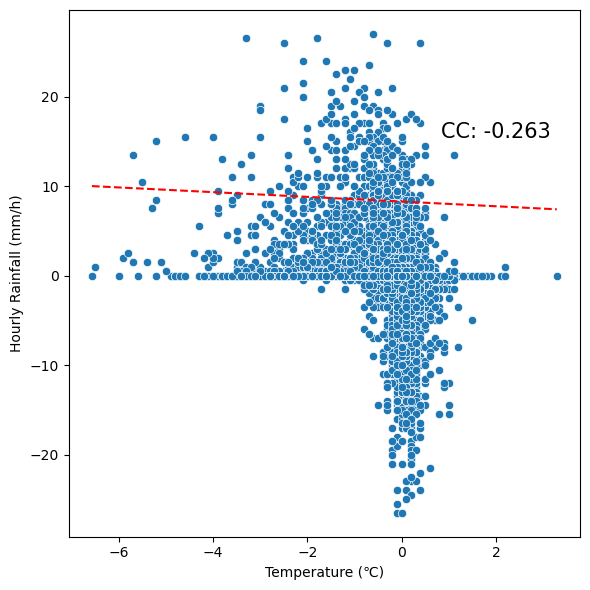

True RH1


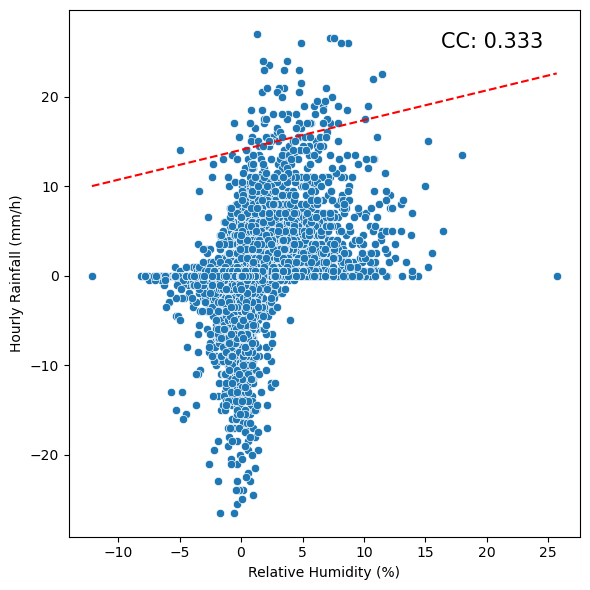

True WS1


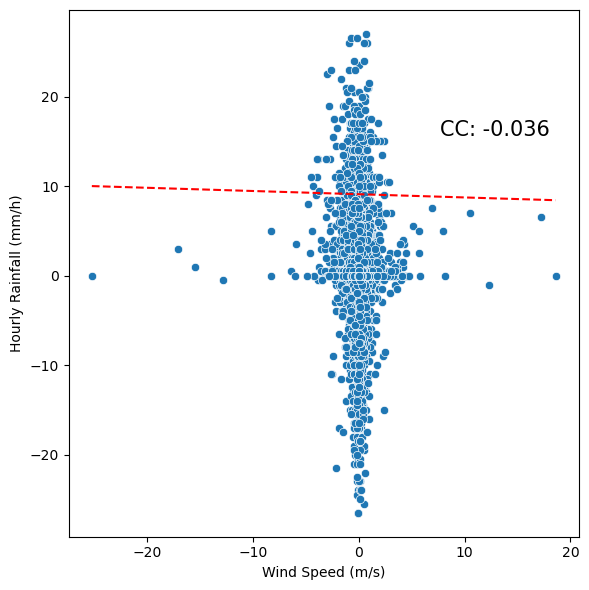

True PRS


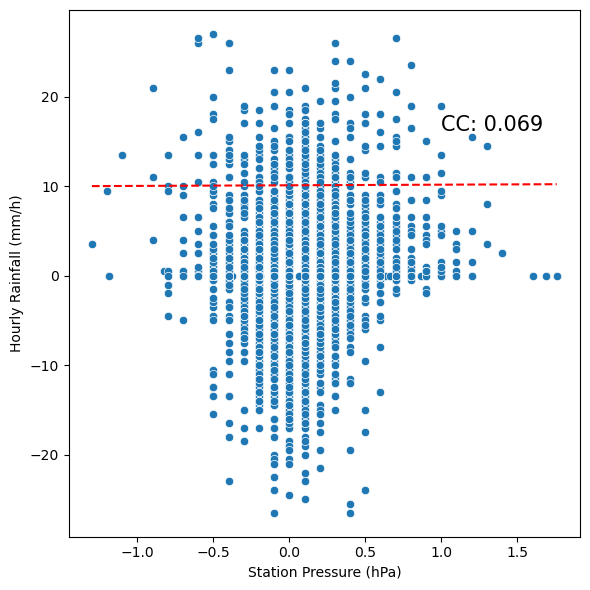

True SLP


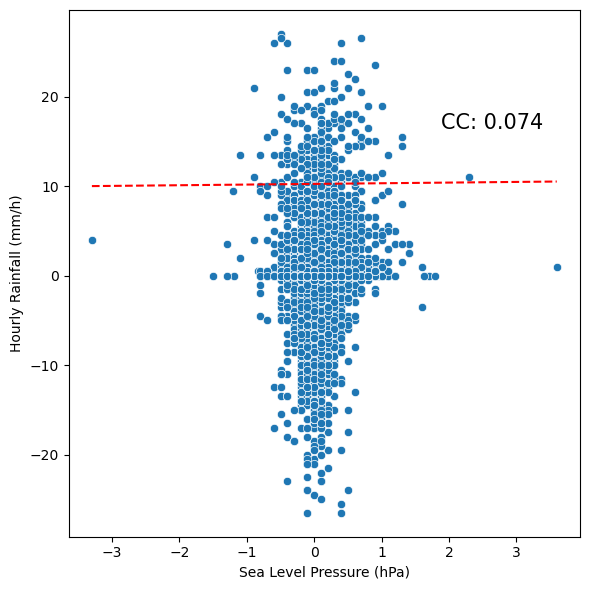

True V-Wind


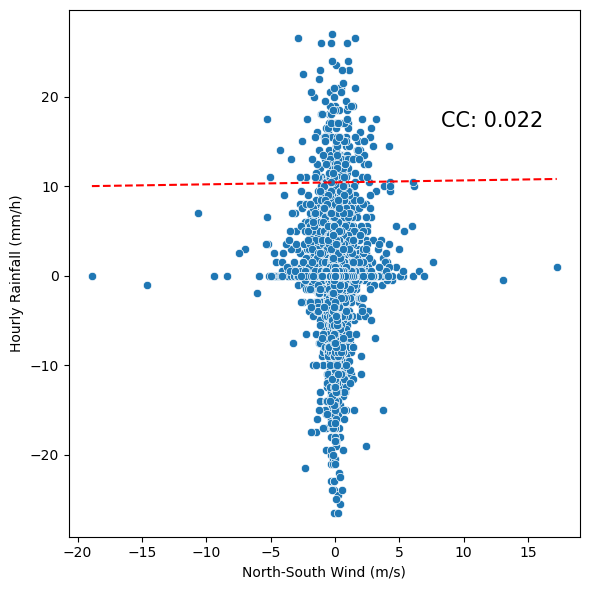

True U-Wind


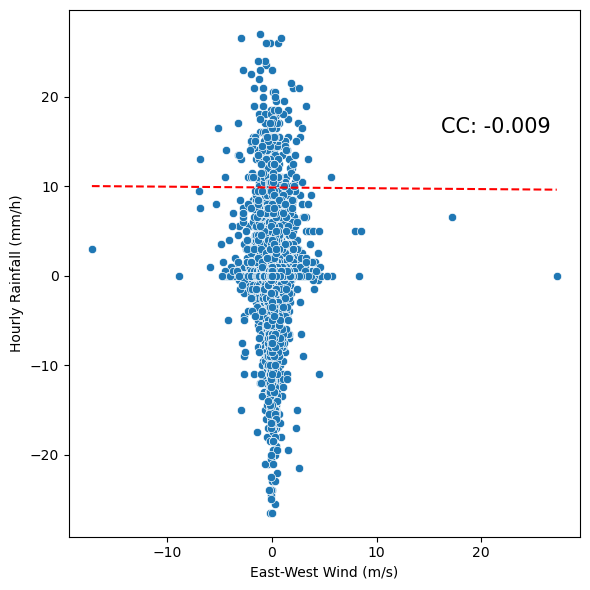

In [84]:
for col in target_cols:
    print(col != 'hour-rain', col)
    if col != 'hour-rain':
        plt.figure(figsize=(6,6))
        ax = sns.scatterplot(data=diff_rain_other_param_df, x=col, y="hour-rain")
        # plot cc line.
        cc = np.corrcoef(diff_rain_other_param_df["hour-rain"].astype(float).values, diff_rain_other_param_df[col].astype(float).values)[0, 1]
        cc = np.round(cc, decimals=3)
        x = np.linspace(diff_rain_other_param_df[col].min(), diff_rain_other_param_df[col].max(), 10)
        y = cc * x + 10 - cc * x.min()
        ax.plot(x, y, color="red", linestyle="--")
        ax.text(np.quantile(x, 0.75), np.quantile(y, 0.75) + 6, f"CC: {cc}", size=15)


        param_label = parameter_info[col]["label"]
        rain_label = parameter_info["hour-rain"]["label"]
        # ax.set_title(f"Scatter plot of {rain_label} and {param_label} over 20 heavy rainfall samples.")
        ax.set_xlabel(param_label)
        ax.set_ylabel(rain_label)
        plt.tight_layout()
        plt.savefig(f"./rain_and_other_parameters/diff_{col}.png")
        plt.show()
        plt.close()